# This notebook contains:
* Code to open station data
* Function for wind masks (station data calm conditions are set to northerlies- the mask ignores calm conditions)
* Function to look at 4-6am and 2-4pm winds
* Wind rose plots
* Station variable diurnal plots

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import dask.dataframe as dd
from dask.distributed import Client
import xarray as xr
from scipy.interpolate import griddata
from scipy.stats import circmean

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Open Station Datasets

In [60]:
# file path
station_fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# open with xarray and dask chunking
station_ds = xr.open_dataset(station_fp, engine="h5netcdf", chunks="auto")

# find station IDs for Townsville & Cairns
bmid_townsville = station_ds.bmid[30] # BOM ID: 032040
bmid_cairns = station_ds.bmid[21]     # BOM ID: 031011

# Selecting for station IDs, select and add units to variables
townsville_wdir = station_ds.wdir.sel(station=30) * units("degrees")
townsville_wspd = (station_ds.wspd.sel(station=30) * (1000/(60*60))) *  units("m/s")
townsville_precip = station_ds.prec.sel(station=30)
townsville_temp = station_ds.temp.sel(station=30)
townsville_mslp = station_ds.mslp.sel(station=30)
# cairns
cairns_wdir = station_ds.wdir.sel(station=21) * units("degrees")
cairns_wspd = (station_ds.wspd.sel(station=21) * (1000/(60*60))) *  units("m/s")
cairns_precip = station_ds.prec.sel(station=21)
cairns_temp = station_ds.temp.sel(station=21)
cairns_mslp = station_ds.mslp.sel(station=21)
townsville_precip

<xarray.DataArray 'prec' (time: 527425)>
dask.array<getitem, shape=(527425,), dtype=float32, chunksize=(527425,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-01T00:30:00 ... 2020-02-01
Attributes:
    units:      mm
    long_name:  Cumulative precipitation since 9am

In [4]:
def JFMA_data(ds):
    var_jan_to_apr = [] # to append data
    years = np.arange(1990,2021,1) # available years of data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()
# townsville variables
wdirT = JFMA_data(townsville_wdir)
wspdT = JFMA_data(townsville_wspd)
precipT = JFMA_data(townsville_precip)
tempT = JFMA_data(townsville_temp)
mslpT = JFMA_data(townsville_mslp)
# cairns variables
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)
precipC = JFMA_data(cairns_precip)
tempC = JFMA_data(cairns_temp)
mslpC = JFMA_data(cairns_mslp)

In [5]:
def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask
wdir_maskT,wspd_maskT = wind_masks(wdirT,wspdT)
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)

In [6]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
print('Mean Townsville wind direction: ',calc_mean_wdir(wdir_maskT))
print('Mean Cairns wind direction: ',calc_mean_wdir(wdir_maskC))

Mean Townsville wind direction:  102.12200367736335
Mean Cairns wind direction:  151.20350399645406


In [7]:
def diurnal_cycle(ds,winds=None):
    morning = [18,19,20]
    four_am = ds.sel(time=ds.time.dt.hour.isin(morning)) #18 UTC = 4am AEST
    afternoon = [4,5,6]
    four_pm = ds.sel(time=ds.time.dt.hour.isin(afternoon)) #6 UTC = 4pm AEST
    
    # create for loop 
    hourly = ds.groupby(ds.time.dt.hour)
    mean_hourly = []
    if winds==True:
        for hour in range(len(hourly)):
            values = hourly[hour].values
            mean = calc_mean_wdir(values)
            mean_hourly.append(mean) 
    else:
        for hour in range(len(hourly)):
            values = hourly[hour].dropna(dim='time').values
            mean = np.mean(values)
            mean_hourly.append(mean) 
    mean_hourly_AEST = np.roll(mean_hourly, shift=10)
    return mean_hourly_AEST, four_am, four_pm # when looking at specific hours: four_am[1]

In [8]:
# townsville
mean_hourly_wdir_AEST_T,four_am_wdirT,four_pm_wdirT = diurnal_cycle(wdir_maskT,winds=True)
mean_hourly_wspd_AEST_T,four_am_wspdT,four_pm_wspdT = diurnal_cycle(wspd_maskT,winds=False)
mean_hourly_precip_AEST_T,four_am_precipT,four_pm_precipT = diurnal_cycle(precipT,winds=False)
mean_hourly_temp_AEST_T,four_am_tempT,four_pm_tempT = diurnal_cycle(tempT,winds=False)
mean_hourly_mslp_AEST_T,four_am_mslpT,four_pm_mslpT = diurnal_cycle(mslpT,winds=False)
# cairns
mean_hourly_wdir_AEST_C,four_am_wdirC,four_pm_wdirC = diurnal_cycle(wdir_maskC,winds=True)
mean_hourly_wspd_AEST_C,four_am_wspdC,four_pm_wspdC = diurnal_cycle(wspd_maskC,winds=False)
mean_hourly_temp_AEST_C,four_am_tempC,four_pm_tempC = diurnal_cycle(tempC,winds=False)
mean_hourly_mslp_AEST_C,four_am_mslpC,four_pm_mslpC = diurnal_cycle(mslpC,winds=False)

In [59]:
ne_wdirT = wdir_maskT[(wdir_maskT>=0*units('degrees')) & (wdir_maskT<=90*units('degrees'))]
se_wdirT = wdir_maskT[(wdir_maskT>270*units('degrees')) & (wdir_maskT<=360*units('degrees'))]

ne_hour = ne_wdirT.groupby(ne_wdirT.time.dt.hour)
se_hour = se_wdirT.groupby(se_wdirT.time.dt.hour)

# ne_hour_AEST = np.roll(ne_hourcount, shift=10)
# plt.plot(np.arange(0,24,1),ne_hourly_count_AEST,linewidth=3,color='royalblue')
# plt.title('Townsville NE Wind Direction Count per Hour')
# plt.xlabel('AEST Hour')
# plt.ylabel('Count')
# plt.xlim(0,23)
# plt.grid()
afternoon = [4,5,6]
morning = [18,19,20]
seabreezeT = ne_wdirT.sel(time=ne_wdirT.time.dt.hour.isin(morning))
se_aft_T = se_wdirT.sel(time=se_wdirT.time.dt.hour.isin(morning))
all_afternoon_timesT = wdir_maskT.sel(time=wdir_maskT.time.dt.hour.isin(afternoon)).dropna(dim='time')
len(se_aft_T)/len(all_afternoon_timesT)


0.0731082654249127

# Plot windroses

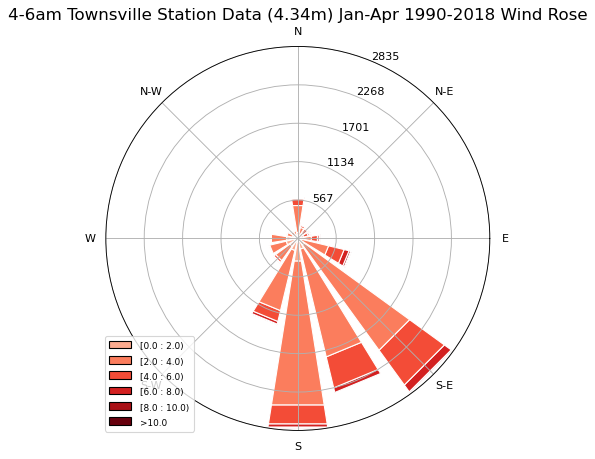

In [36]:
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

orig_map = plt.cm.get_cmap('Reds')
cmap_range_start = 0.3
cmap_range_end = 1.0
cmap_colors = orig_map(np.linspace(cmap_range_start, cmap_range_end, 256))
cmap_reds_custom_custom = LinearSegmentedColormap.from_list("RedsCustom", cmap_colors)
ax = WindroseAxes.from_ax(figsize=(6,15))
ax.bar(four_am_wdirT, four_am_wspdT, bins=[0,2,4,6,8,10], opening=0.8, edgecolor='white', cmap=cmap_reds_custom_custom)
ax.set_title("4-6am Townsville Station Data (4.34m) Jan-Apr 1990-2018 Wind Rose",fontsize=15)
ax.set_legend();

Text(0.5, 36.72222222222221, 'AEST Hour')

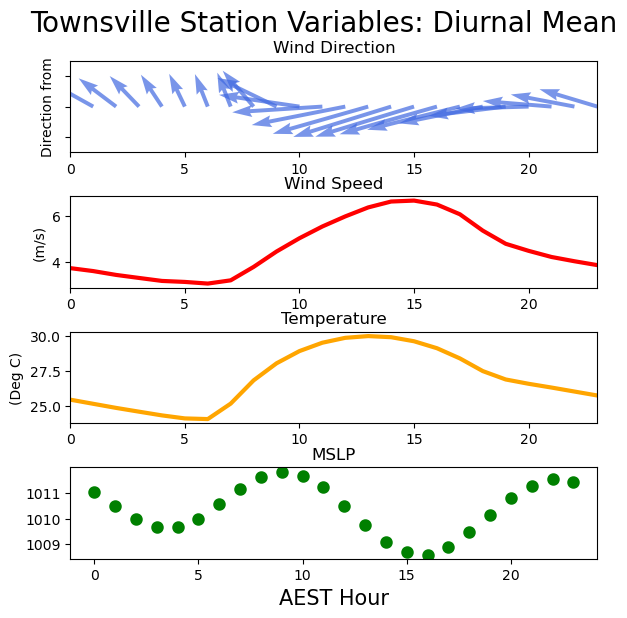

In [29]:
#plot diurnal cycle
fig,ax = plt.subplots(4,1, figsize=[6,6])
fig.patch.set_facecolor('white')
fig.suptitle('Townsville Station Variables: Diurnal Mean',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST_T + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)

scaling_factor = 0.5
# Create wind direction arrows using quiver with the scaling factor
ax[0].quiver(range(len(wind_speed)), [0] * len(wind_speed), scaling_factor * wind_speed * np.cos(wind_direction_radians),
          scaling_factor * wind_speed * np.sin(wind_direction_radians),
          angles='xy', scale_units='xy', scale=0.7, color='royalblue',alpha=0.7)

# plot wind barbs
# barb_length = 5  # Adjust the barb length as needed
# ax[0].barbs(range(len(wind_direction_degrees)), [0] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
#           barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',flip_barb=True)
# ax[0].scatter(np.arange(0,24,1),mean_hourly_wdir_AEST_C,linewidth=3,color='royalblue')
ax[1].plot(np.arange(0,24,1),mean_hourly_wspd_AEST_T,linewidth=3,color='red')
ax[2].plot(np.arange(0,24,1),mean_hourly_temp_AEST_T,linewidth=3,color='orange')
ax[3].scatter(np.arange(0,24,1),mean_hourly_mslp_AEST_T,linewidth=3,color='green')
# y_mean = []
# for i in np.arange(0,24,1):
#     i = wspd_maskC.mean()#calc_mean_wdir(wdir_maskT)
#     y_mean.append(i)
# plt.plot(np.arange(0,24,1),y_mean,linestyle='--',color='grey')
ax[0].set_ylabel('Direction from')
ax[1].set_ylabel('(m/s)')
ax[2].set_ylabel('(Deg C)')
ax[0].set_ylim(-3,3)
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
ax[2].set_xlim(0,23)
# ax[3].set_xlim(0,23)
ax[0].set_yticklabels([])
ax[0].set_title('Wind Direction')
ax[1].set_title('Wind Speed')
ax[2].set_title('Temperature')
ax[3].set_title('MSLP')
ax[3].set_xlabel('AEST Hour',fontsize=15)